# Домашнее задание №6. Нейросети в обработке текста

In [1]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 8.2 MB 38.3 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=3b71c5203a203a53dbbbf13f09cd4ebca3b812024bcc87f1b00ecabde027a177
  Stored in directory: /root/.cache/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=a3de193bc45bcce1fc4e49e08b6590350ac25667c97aaca551f391c8f1ab128f
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built stop-words docopt


In [42]:
#предобработка
from string import punctuation
#from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk

nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Задание

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [3]:
max_words = 2000
max_len = 20
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

### 0. Загрузка данных<a id='section_0'></a>

In [5]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maximgasilin
Your Kaggle Key: ··········


100%|██████████| 1.89M/1.89M [00:01<00:00, 1.86MB/s]

In [8]:
# пути к данным
root_data_path = 'twitter-sentiment-analysis-hatred-speech'

dataset_train  = root_data_path + '/train.csv'
dataset_test  = root_data_path + '/test.csv'

In [9]:
#загрузка данных
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

In [10]:
#тренировочный датасет
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [11]:
#тестовый датасет
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [12]:
#разделение тренировочного датасета на обучающий и валидационный
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)

In [13]:
#датасет для обучения модели
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [14]:
df_train['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [15]:
#датасет для валидации модели
df_valid.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [16]:
df_valid['label'].value_counts()

0    8905
1     684
Name: label, dtype: int64

### 1. Предобработка данных <a id='section_1'></a>

In [17]:
#множество стоп-слов
sw = set(stopwords.words('english'))
print(sw)

{'didn', 'why', 'me', 'too', 'he', 'haven', 'more', 'by', 'against', "isn't", "won't", "mightn't", 'if', 'out', 'now', 'wouldn', 'other', 'been', 'and', 'will', 'it', 'aren', 're', 'them', 'down', 'was', 'very', "couldn't", 'between', 'such', 'below', 'ain', 'have', 'himself', 'themselves', 't', 'y', "you'd", "she's", 'nor', 'few', 'hasn', 'but', 'only', 'when', "shan't", 'there', 'they', 'myself', 'him', 'i', 'while', 'having', 'further', 'hadn', 'won', 'some', 'where', 'from', 'shan', 'weren', 'its', 'am', 'can', "that'll", 'how', 'should', "hasn't", "doesn't", 'hers', 'under', 'here', "you've", 'herself', 'both', 'couldn', 'my', "should've", "wouldn't", 'at', 'once', 'of', 'or', 'yourselves', 'in', "don't", 'doesn', 'then', 'before', 'being', 'with', 'is', 'through', 's', 'above', 'ma', 'any', 'your', 'll', 'needn', 'be', 'do', 'just', "you'll", "you're", 'that', 'd', 'theirs', 'over', 'a', 'you', 'each', 'because', 'the', "needn't", 'ours', 'what', "weren't", 'than', 'doing', 'migh

In [18]:
#пунктуация
exclude = set(punctuation)
print(exclude)

{'&', ']', '~', '?', '/', '{', ':', '[', '@', ')', ',', '.', '<', '-', '+', '^', '_', '}', '*', '>', ';', "'", '#', '(', '%', '"', '`', '\\', '!', '$', '|', '='}


In [20]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [21]:
#морфологический анализ для английского текста
lemmatizer = WordNetLemmatizer()

#пример работы
lemmatizer.lemmatize('dogs'), lemmatizer.lemmatize('says')

('dog', 'say')

In [22]:
#функция преобразования текста
def preprocess_text(txt):
    #преобразуем входные данные в строку
    txt = str(txt)
    #удяляем знаки пунктуации
    txt = "".join(c for c in txt if c not in exclude)
    #приводим все к нижнему регистру
    txt = txt.lower()
    #лематизация
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [23]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:00<00:00, 24662.08it/s]


In [24]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [25]:
#токенезация (разбиваем строку на слова)
tokens = word_tokenize(train_corpus)
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [26]:
#отфильтруем токены (проверяем, чтобы все символы были или буквы или цифры)
tokens_filtered = [word for word in tokens if word.isalnum()]
print(tokens_filtered)

['summer', 'summeriscoming', 'swimming', 'picoftheday', 'tattoo', 'issho', 'pulsera', 'fluyendo', 'dese', 'nigga', 'show', 'dese', 'otha', 'bitch', 'fb', 'snap', 'nd', 'twitter', 'attention', 'dey', 'girl', 'true', 'boost', 'immune', 'system', 'allow', 'body', 'use', 'energy', 'reading', 'manuscript', 'wanting', 'stop', 'good', 'evening', 'good', 'night', 'baby', 'say', 'hate', 'today', 'im', 'dj', 'lol', 'womanofmanyhats', 'instamood', 'love', 'silentdisco', 'christmas', 'eve', 'christmas', 'adam', 'towards', 'men', 'feminism', 'lover', 'stop', 'angry', 'visit', 'usgtgtgt', 'lover', 'friend', 'astrologer', 'love', 'best', 'wish', 'outside', 'gym', 'fitness', 'macboys', 'blue', 'white', 'grey', 'user', 'stress', 'pretty', 'ditch', 'laugh', 'exercise', 'headisease', 'user', 'user', 'user', 'creative', 'sent', 'user', 'thebigscreen', 'user', 'weekend', 'thankful', 'coffee', 'thankful', 'positive', 'user', 'whisky', 'connoisseur', 'kit', 'fathersday', 'whisky', 'make', 'innovativenous', '

In [27]:
#соберем max_words наиболее частых токенов

#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 12209, 'love': 1886, 'day': 1875, 'happy': 1183, 'u': 1161, 'amp': 1099, 'time': 851, 'life': 844, 'im': 785, 'today': 742, ...})

In [28]:
#берем max_words наиболее часто встречающихся токенов
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'time', 'life', 'im', 'today'])

In [29]:
#словарь слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}
vocabulary

{'user': 0,
 'love': 1,
 'day': 2,
 'happy': 3,
 'u': 4,
 'amp': 5,
 'time': 6,
 'life': 7,
 'im': 8,
 'today': 9,
 'like': 10,
 'new': 11,
 'get': 12,
 'positive': 13,
 'thankful': 14,
 'father': 15,
 'make': 16,
 'good': 17,
 'people': 18,
 'one': 19,
 'bihday': 20,
 'cant': 21,
 'go': 22,
 'smile': 23,
 'see': 24,
 'want': 25,
 'friend': 26,
 'dont': 27,
 'take': 28,
 'work': 29,
 'weekend': 30,
 'healthy': 31,
 'girl': 32,
 'got': 33,
 'need': 34,
 'fun': 35,
 'week': 36,
 'family': 37,
 'way': 38,
 'summer': 39,
 'great': 40,
 'friday': 41,
 'best': 42,
 '2': 43,
 'beautiful': 44,
 'bull': 45,
 'going': 46,
 'year': 47,
 'wait': 48,
 'know': 49,
 'thing': 50,
 'first': 51,
 'really': 52,
 'music': 53,
 'back': 54,
 'morning': 55,
 'world': 56,
 'home': 57,
 'think': 58,
 'look': 59,
 'come': 60,
 'feel': 61,
 'affirmation': 62,
 'dad': 63,
 'tomorrow': 64,
 'cute': 65,
 'fathersday': 66,
 'orlando': 67,
 'never': 68,
 'sad': 69,
 'trump': 70,
 'night': 71,
 'happiness': 72,
 'much

In [30]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [31]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]])

x_train.shape, x_valid.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [32]:
#данные после подготовки к обучению
torch.from_numpy(x_train[0])

tensor([  39, 1093,  580, 1375,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

### 2. Построение и обучение модели<a id='section_2'></a>

In [33]:
#Датасет
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [34]:
#создание представителей классов Dataset и Dataloader
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [35]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([  33,  980, 1462,  114,    0,    0,  104,  888,  648,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
torch.Size([512]) tensor(0)


In [36]:
#сверточная нейронная сеть
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [37]:
#инициализация модели
model = Net(vocab_size=max_words)
print(model)

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [38]:
#компиляция модели
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [39]:
#обучение модели
model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/44]. Loss: 0.711. Acc: 0.080. Val loss: 0.607. Val acc: 0.929
Epoch [2/10]. Step [1/44]. Loss: 0.238. Acc: 0.928. Val loss: 0.068. Val acc: 0.929
Epoch [3/10]. Step [1/44]. Loss: 0.195. Acc: 0.939. Val loss: 0.875. Val acc: 0.929
Epoch [4/10]. Step [1/44]. Loss: 0.208. Acc: 0.920. Val loss: 0.033. Val acc: 0.929
Epoch [5/10]. Step [1/44]. Loss: 0.172. Acc: 0.930. Val loss: 0.914. Val acc: 0.929
Epoch [6/10]. Step [1/44]. Loss: 0.134. Acc: 0.947. Val loss: 0.169. Val acc: 0.942
Epoch [7/10]. Step [1/44]. Loss: 0.068. Acc: 0.977. Val loss: 0.035. Val acc: 0.945
Epoch [8/10]. Step [1/44]. Loss: 0.062. Acc: 0.977. Val loss: 0.003. Val acc: 0.947
Epoch [9/10]. Step [1/44]. Loss: 0.053. Acc: 0.980. Val loss: 0.000. Val acc: 0.947
Epoch [10/10]. Step [1/44]. Loss: 0.040. Acc: 0.984. Val loss: 0.035. Val acc: 0.941
Training is finished!


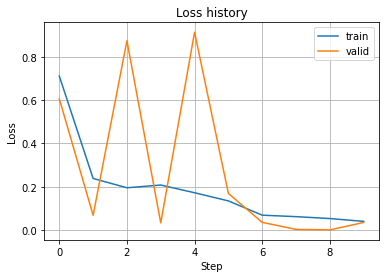

In [40]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

### 3. Выводы<a id='section_3'></a>

In [41]:
#тестирование модели
input = torch.from_numpy(x_test).long()
test_outputs = model(input)
outputs_label = np.where(test_outputs > 0.5, 1, 0)
test_outputs, outputs_label

(tensor([[5.6316e-04],
         [6.1339e-04],
         [3.7021e-10],
         ...,
         [1.5669e-03],
         [2.6819e-06],
         [2.4702e-05]], grad_fn=<SigmoidBackward0>), array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]))

1. Метрика на валидации растет немонотонно. Поэтому увеличение числа эпох не приводит к улучшению метрики на валидации.

2. Снижение скорости обучения способствует улучшению метрики.

3. Добавление Dropout не приводит к улучшению метрики.